<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Análise de Dados: Análise Exploratória de Dados de Logística II
Caderno de **Exercícios**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>Manipulação;</li>
  <li>Visualização;</li>
  <li>Storytelling.</li>
</ol>


---

# **Exercícios**

Este *notebook* deve servir como um guia para **você continuar** a construção da sua própria análise exploratória de dados. Fique a vontade para copiar os códigos da aula mas busque explorar os dados ao máximo. Por fim, publique seu *notebook* no [Kaggle](https://www.kaggle.com/).

---

# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

Extração de dados de um serviço de entregas em Distrito Federal para descobrir e solucionar possíveis problemas

## 2\. Pacotes e bibliotecas

Importando os pacotes necessários.

In [149]:
import json
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

Carregamento dos dados ja preparados anteriormente,porém com os dados brutos em formato jason e salvados na variável **deliveries.json**

In [113]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json

## 3\. Exploração de dados

Visualização breve dos dados após salvá-los em um um dataframe

In [114]:
with open('deliveries.json', mode='r',encoding='utf8') as entregas:
  dado_entregas = json.load(entregas)

deliveries_df = pd.DataFrame(dado_entregas)

deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


Usando o **pd.json_normalize( )** para separar os dados da coluna origin em duas colunas e criar um dataframe com elas

In [115]:
origin_df = pd.json_normalize(deliveries_df['origin'])
origin_df.head()

,lng,lat
0,-48.054989,-15.838145
1,-48.054989,-15.838145
2,-48.054989,-15.838145
3,-47.893662,-15.805118
4,-48.054989,-15.838145


Unindo o dataframe **origin_df** ao dataframe **deliveries_df** e
removendo a coluna **origin**,em seguida reorganizando as posições das colunas, e por fim, renomeando as colunas **lng** e **lat** recem adicionadas e visualizando as primeiras linhas

In [116]:
deliveries_df = pd.merge(left = deliveries_df, right = origin_df, how ='inner', left_index=True, right_index=True)
deliveries_df = deliveries_df.drop('origin', axis=1)
deliveries_df = deliveries_df[['name', 'region', 'lng', 'lat', 'vehicle_capacity', 'deliveries']]
deliveries_df.rename(columns={'lng': 'Hub_Lng', 'lat': 'Hub_Lat'}, inplace=True)
deliveries_df.head()

,name,region,Hub_Lng,Hub_Lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


Agora o tratamento da coluna **deliveries**

Primeiro utilizando o **.explode( )** para transformar uma linha de dados em coluna, onde cada elemento se torna uma linha

In [117]:
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")
deliveries_exploded_df.head()

,deliveries
0,"{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'po..."
0,"{'id': '320c94b17aa685c939b3f3244c3099de', 'po..."
0,"{'id': '3663b42f4b8decb33059febaba46d5c8', 'po..."
0,"{'id': 'e11ab58363c38d6abc90d5fba87b7d7', 'poi..."
0,"{'id': '54cb45b7bbbd4e34e7150900f92d7f4b', 'po..."


Agora extraindo os valores de **size** e renomeando a coluna **deliveries** de acordo com o dado, e então concatenando-os

In [118]:
deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)

deliveries_normalized_df.head()

,delivery_size,delivery_lng,delivery_lat
0,9,-48.116189,-15.848929
0,2,-48.118195,-15.850772
0,1,-48.112483,-15.847871
0,2,-48.118023,-15.846471
0,7,-48.114898,-15.858055


Remoção da coluna **deliveries**,agora que ja foram adicionadas outras colunas renomeadas e união do dataframe **deliveries_normalized_df** ao **deliveries_df**, mas dessa vez, pelo dado da direita.

In [119]:
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df = deliveries_df.drop('deliveries',axis=1)
deliveries_df.reset_index(inplace=True, drop=True)

deliveries_df.head()

,name,region,Hub_Lng,Hub_Lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


## 4\. Manipulação

Isolando as três regiões em uma nova variável para usar a geocodificação reversa

In [120]:
hub_df = deliveries_df[['region', 'Hub_Lng', 'Hub_Lat']]
hub_df = hub_df.drop_duplicates().sort_values(by='region').reset_index(drop=True)
hub_df.head()

,region,Hub_Lng,Hub_Lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


Utilizando o geolocalizador para descobrir o local das coordenadas das regiões.

In [121]:
geolocator = Nominatim(user_agent="ebac_geocoder")
location = geolocator.reverse("-15.657013854445248, -47.802664728268745")

print(json.dumps(location.raw, indent=2, ensure_ascii=False))

{
  "place_id": 46410411,
  "licence": "Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright",
  "osm_type": "way",
  "osm_id": 240210480,
  "lat": "-15.656916027876347",
  "lon": "-47.80264463632131",
  "class": "highway",
  "type": "secondary",
  "place_rank": 26,
  "importance": 0.0533433333333333,
  "addresstype": "road",
  "name": "Rua 7",
  "display_name": "Rua 7, Quadra 2, Sobradinho, Região Geográfica Imediata do Distrito Federal, Região Integrada de Desenvolvimento do Distrito Federal e Entorno, Região Geográfica Intermediária do Distrito Federal, Distrito Federal, Região Centro-Oeste, 73015-127, Brasil",
  "address": {
    "road": "Rua 7",
    "residential": "Quadra 2",
    "suburb": "Sobradinho",
    "town": "Sobradinho",
    "municipality": "Região Geográfica Imediata do Distrito Federal",
    "county": "Região Integrada de Desenvolvimento do Distrito Federal e Entorno",
    "state_district": "Região Geográfica Intermediária do Distrito Federal",
    "state

Extraindo informações de ruas e de bairros das três regiões

In [122]:
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [123]:
hub_df["coordinates"] = hub_df["Hub_Lat"].astype(str)  + ", " + hub_df["Hub_Lng"].astype(str)
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
hub_df.head()

,region,Hub_Lng,Hub_Lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745","(Rua 7, Quadra 2, Sobradinho, Região Geográfic..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872","(SQS 303, Asa Sul, Brasília, Plano Piloto, Reg..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


Usando o normalize na coluna **geodata** para separar os dados em varias colunas.

In [124]:
hub_geo_df = pd.json_normalize(hub_df['geodata'].apply(lambda data: data.raw))
hub_geo_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,class,type,place_rank,importance,...,address.state,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.neighbourhood,address.city,address.shop,address.house_number
0,46410411,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,240210480,-15.656916027876347,-47.80264463632131,highway,secondary,26,0.053343,...,Distrito Federal,BR-DF,Região Centro-Oeste,73015-127,Brasil,br,NaN,NaN,NaN,NaN
1,46401425,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,66353368,-15.805172757199022,-47.893723539491205,highway,residential,26,0.053411,...,Distrito Federal,BR-DF,Região Centro-Oeste,70330-400,Brasil,br,SQS 303,Brasília,NaN,NaN
2,43777060,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,shop,pastry,30,0.000010,...,Distrito Federal,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,Taguatinga,Armazém do Bolo,lote 4/8


Atualizando a variável para renomear as colunas e organizar suas informações, e remover uma coluna desnecessária.

In [125]:
hub_geo_df = hub_geo_df[["address.town", "address.suburb", "address.city"]]
hub_geo_df.rename(columns={"address.town": "Hub_Town", "address.suburb": "Hub_Suburb", "address.city": "Hub_City"}, inplace=True)
hub_geo_df["Hub_City"] = np.where(hub_geo_df["Hub_City"].notna(), hub_geo_df["Hub_City"], hub_geo_df["Hub_Town"])
hub_geo_df["Hub_Suburb"] = np.where(hub_geo_df["Hub_Suburb"].notna(), hub_geo_df["Hub_Suburb"], hub_geo_df["Hub_City"])
hub_geo_df = hub_geo_df.drop("Hub_Town", axis=1)
hub_geo_df.head()

,Hub_Suburb,Hub_City
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


Agora juntando os dois dataframes com o merge.

In [126]:
hub_df =pd.merge(left=hub_df, right=hub_geo_df, left_index=True, right_index=True)
hub_df = hub_df[['region', 'Hub_Suburb', 'Hub_City']]
hub_df.head()

,region,Hub_Suburb,Hub_City
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


E agora unindo com o dataframe principal e organizando umas coisinhas.

In [127]:
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how='inner', on='region')
deliveries_df = deliveries_df[['name', 'region', 'Hub_Lng', 'Hub_Lat', 'Hub_City', 'Hub_Suburb', 'vehicle_capacity', 'delivery_size', 'delivery_lng', 'delivery_lat']]

In [128]:
deliveries_df.head()

,name,region,Hub_Lng,Hub_Lat,Hub_City,Hub_Suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


Pegando as localizações das coordenadas e unindo-as ao dataframe principal.

In [129]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv

In [130]:
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [131]:
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
deliveries_df = deliveries_df.rename(columns = {'name' : 'Nome', 'region' : 'Região', 'Hub_City':'Hub_Cidade', 'Hub_Suburb':'Hub_Subúrbio', 'vehicle_capacity':'Capacidade_Veiculo', 'delivery_size':'Tamanho_Delivery', 'delivery_lng':'Delivery_Lng', 'delivery_lat':'Delivery_Lat', 'delivery_city':'Delivery_Cidade', 'delivery_suburb':'Delivery_Subúrbio'})

deliveries_df.head()

,Nome,Região,Hub_Lng,Hub_Lat,Hub_Cidade,Hub_Subúrbio,Capacidade_Veiculo,Tamanho_Delivery,Delivery_Lng,Delivery_Lat,Delivery_Cidade,Delivery_Subúrbio
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


Verificação de valores vazios ou nulos.

In [132]:
deliveries_df.isna().any()

Nome                  False
Região                False
Hub_Lng               False
Hub_Lat               False
Hub_Cidade            False
Hub_Subúrbio          False
Capacidade_Veiculo    False
Tamanho_Delivery      False
Delivery_Lng          False
Delivery_Lat          False
Delivery_Cidade        True
Delivery_Subúrbio      True
dtype: bool

In [133]:
100 * (deliveries_df["Delivery_Cidade"].isna().sum() / len(deliveries_df))

0.26754738276724477

In [134]:
100 * (deliveries_df['Delivery_Subúrbio'].isna()).sum() / len(deliveries_df)

25.133262804783158

Proporção dos dados em porcentaegem.

In [135]:
prop_df = deliveries_df[["Delivery_Subúrbio"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

Delivery_Subúrbio
Brasília             0.084564
Asa Norte            0.076639
Taguatinga           0.063363
Asa Sul              0.059263
Águas Claras         0.056598
Guará                0.055619
Samambaia            0.026514
Sobradinho           0.018148
Recanto das Emas     0.015029
P Sul                0.012807
Name: count, dtype: float64

In [136]:
prop_df = deliveries_df[['Delivery_Cidade']].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

Delivery_Cidade     
Brasília                0.234195
Taguatinga              0.071625
Sudoeste / Octogonal    0.069504
Ceilândia               0.059661
Águas Claras            0.058293
Guará                   0.055619
Lago Sul                0.045620
Sobradinho              0.045412
Lago Norte              0.040832
Gama                    0.034880
Name: count, dtype: float64

## 5\. Visualização

Download de dados do mapa de Distrito Federal.

In [137]:
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

replace ./maps/ASB_Cemiterio_A.dbf? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [142]:
hub_df = deliveries_df[["Região", "Hub_Lng", "Hub_Lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["Hub_Lng"], hub_df["Hub_Lat"]))
geo_hub_df.head()

,Região,Hub_Lng,Hub_Lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


Após colocar as três regiões em um dataframe,foi criado outro dataframe com uma nova coluna ao final.

In [143]:
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["Delivery_Lng"], deliveries_df["Delivery_Lat"]))
geo_deliveries_df = geo_deliveries_df.rename(columns={'geometry':'Geometria'})
geo_deliveries_df.head()

,Nome,Região,Hub_Lng,Hub_Lat,Hub_Cidade,Hub_Subúrbio,Capacidade_Veiculo,Tamanho_Delivery,Delivery_Lng,Delivery_Lat,Delivery_Cidade,Delivery_Subúrbio,Geometria
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


Visualização da dimensão do mapa

In [144]:
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


Gerando o mapa

<ipython-input-147-f71c3a940409>:21: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


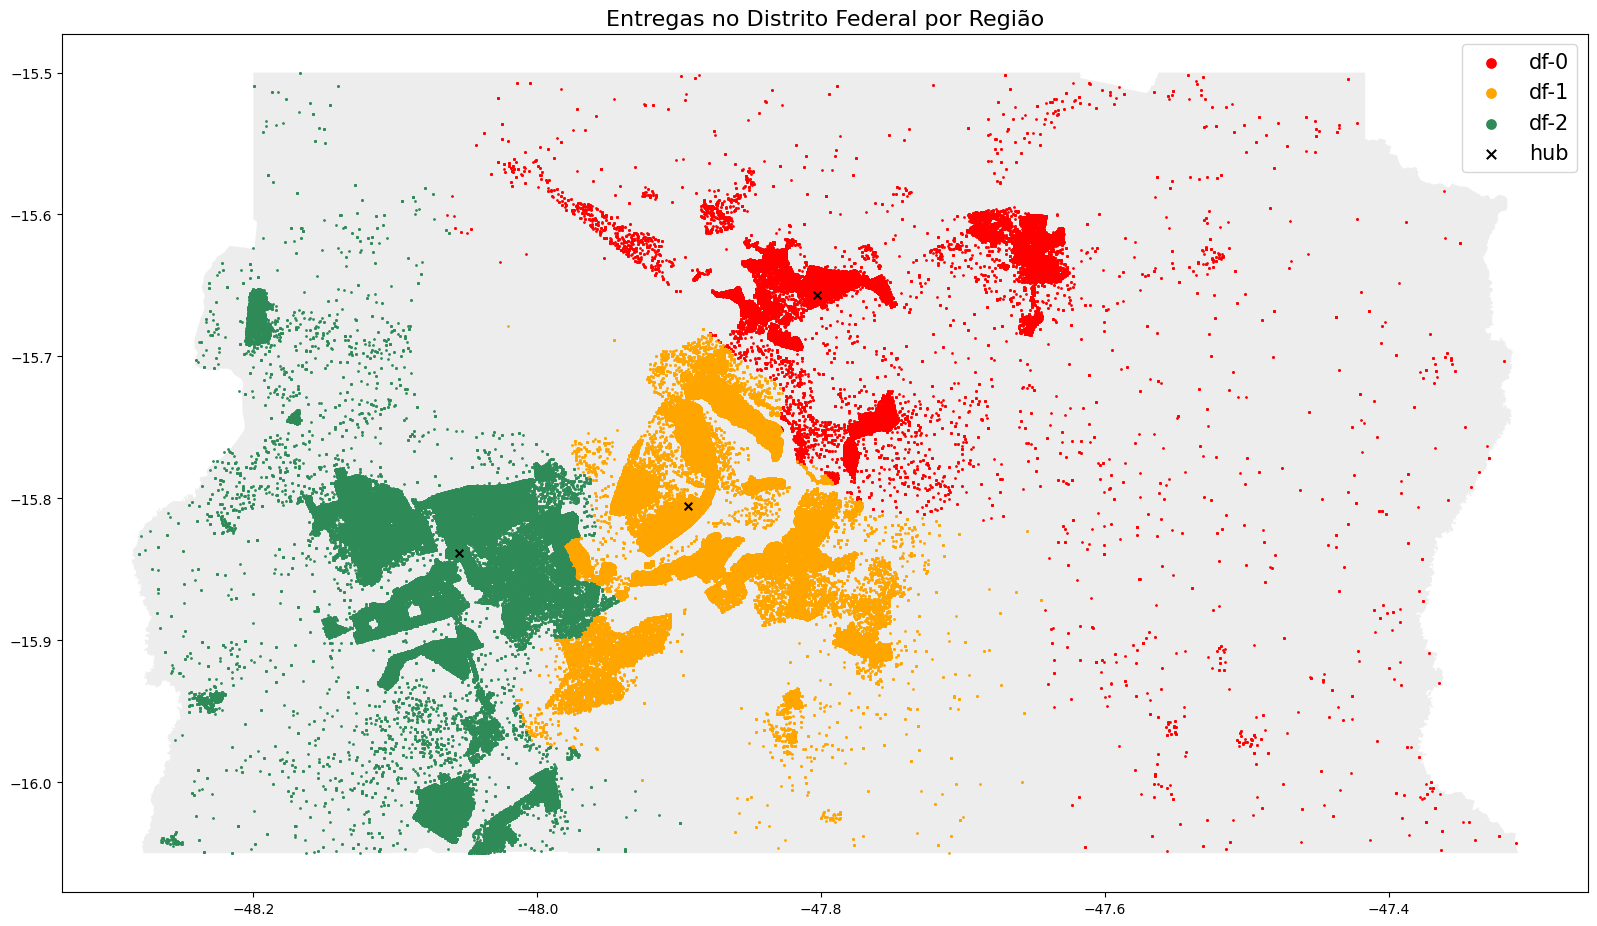

In [147]:
#Setando a coluna
geo_deliveries_df = geo_deliveries_df.set_geometry('Geometria')

#Plot Vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

#Distrito Federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

#Entregas
geo_deliveries_df.query("Região == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("Região == 'df-1'").plot(ax=ax, markersize=1, color="orange", label="df-1")
geo_deliveries_df.query("Região == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

#Hubs
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

#Legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([45])

Pode-se observar que as regiões 0 e 2 parecem cobrir areas maiores e consequentemente mais longinquas,o que pode acarretar em maiores gastos,  assim como consequentemente,aumento do preço ao realizar as entregas.

Criando outro dataframe com a porcentagem de entregas.

In [148]:
data = pd.DataFrame(deliveries_df[['Região', 'Capacidade_Veiculo']].value_counts(normalize=True)).reset_index()
data = deliveries_df[['Região', 'Capacidade_Veiculo']].value_counts(normalize=True).reset_index(name='Porcentagem_Região')
data.head()

,Região,Capacidade_Veiculo,Porcentagem_Região
0,df-1,180,0.478988
1,df-2,180,0.410783
2,df-0,180,0.110229


Gráfico de barras com a proporção de entregas.

<ipython-input-150-721b8ce33f95>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  grafico = sns.barplot(data=data, x="Região", y="Porcentagem_Região", ci=None, palette="bright")
<ipython-input-150-721b8ce33f95>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  grafico = sns.barplot(data=data, x="Região", y="Porcentagem_Região", ci=None, palette="bright")


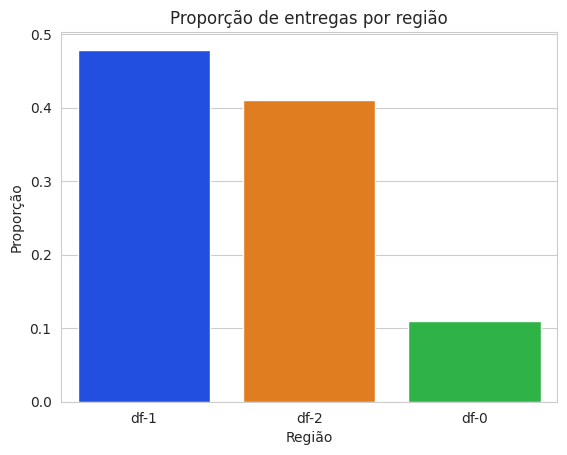

In [150]:
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data, x="Região", y="Porcentagem_Região", ci=None, palette="bright")
  grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção');

A região 0 mostrou pouca concentração de entregas,e, considerando que todos os veículos possuem capacidades de carga equivalentes,poderiam ser deslocados alguns deles para as demais regiões que se mostraram mais concentradas.